<a href="https://colab.research.google.com/github/codingle2/Data_Analysis_Programming_Class/blob/main/improved_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving stockCodeInfo.xlsx to stockCodeInfo.xlsx



[1] 거래량 상위 주식 목록 (상위 5개)
=== 상위 주식 데이터 크롤링 시작 (총 40개 목표) ===
 -> 페이지 1 요청 중...
 -> 페이지 2 요청 중...
                종목명    종목코드     현재가     등락률          거래량
0  KODEX 200선물인버스2X  252670     669    1.21  485,824,031
1               테라뷰  950250  16,000  100.00   66,821,486
2              삼성제약  001360   1,977   11.51   47,083,230
3  KODEX 2차전지산업레버리지  462330   1,814   -0.22   43,192,858
4              현대약품  004310   6,960    5.94   36,848,618

[2] KOSPI 정보
┌──────────────────────────────────────────────────┐
│  🇰🇷  [대한민국] 코스피 (코스피) 상세 현황      │
├──────────────────────────────────────────────────┤
│  현재지수  : 4,143.55                          │
│  등락률    : ▼ -11.30 (-0.27%) 하락              │
├──────────────────────────────────────────────────┤
│  장 상태   : CLOSE                          │
│  기준시간  : 2025-12-09 17:00:01         │
│  거래소    : KOSPI (KS)              │
├──────────────────────────────────────────────────┤
│  📊 일봉 차트 (클릭하여 보기):                   │
│  https://ssl.pstatic.net/imgfinanc

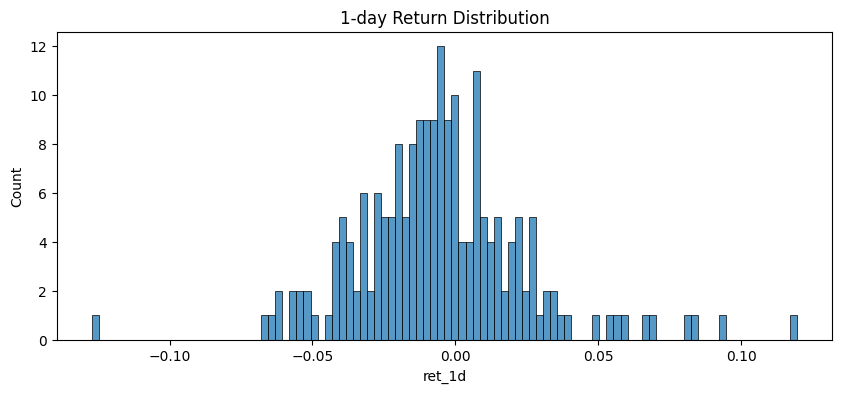

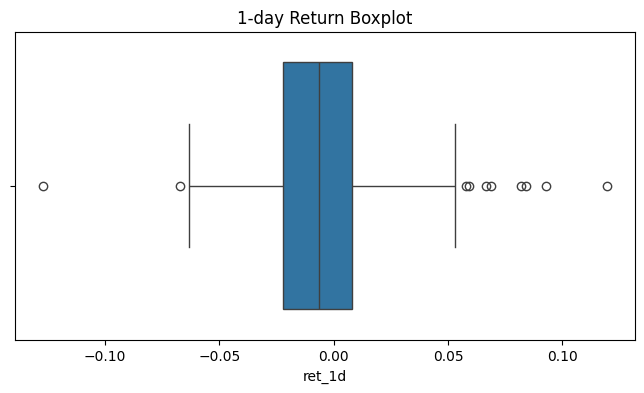

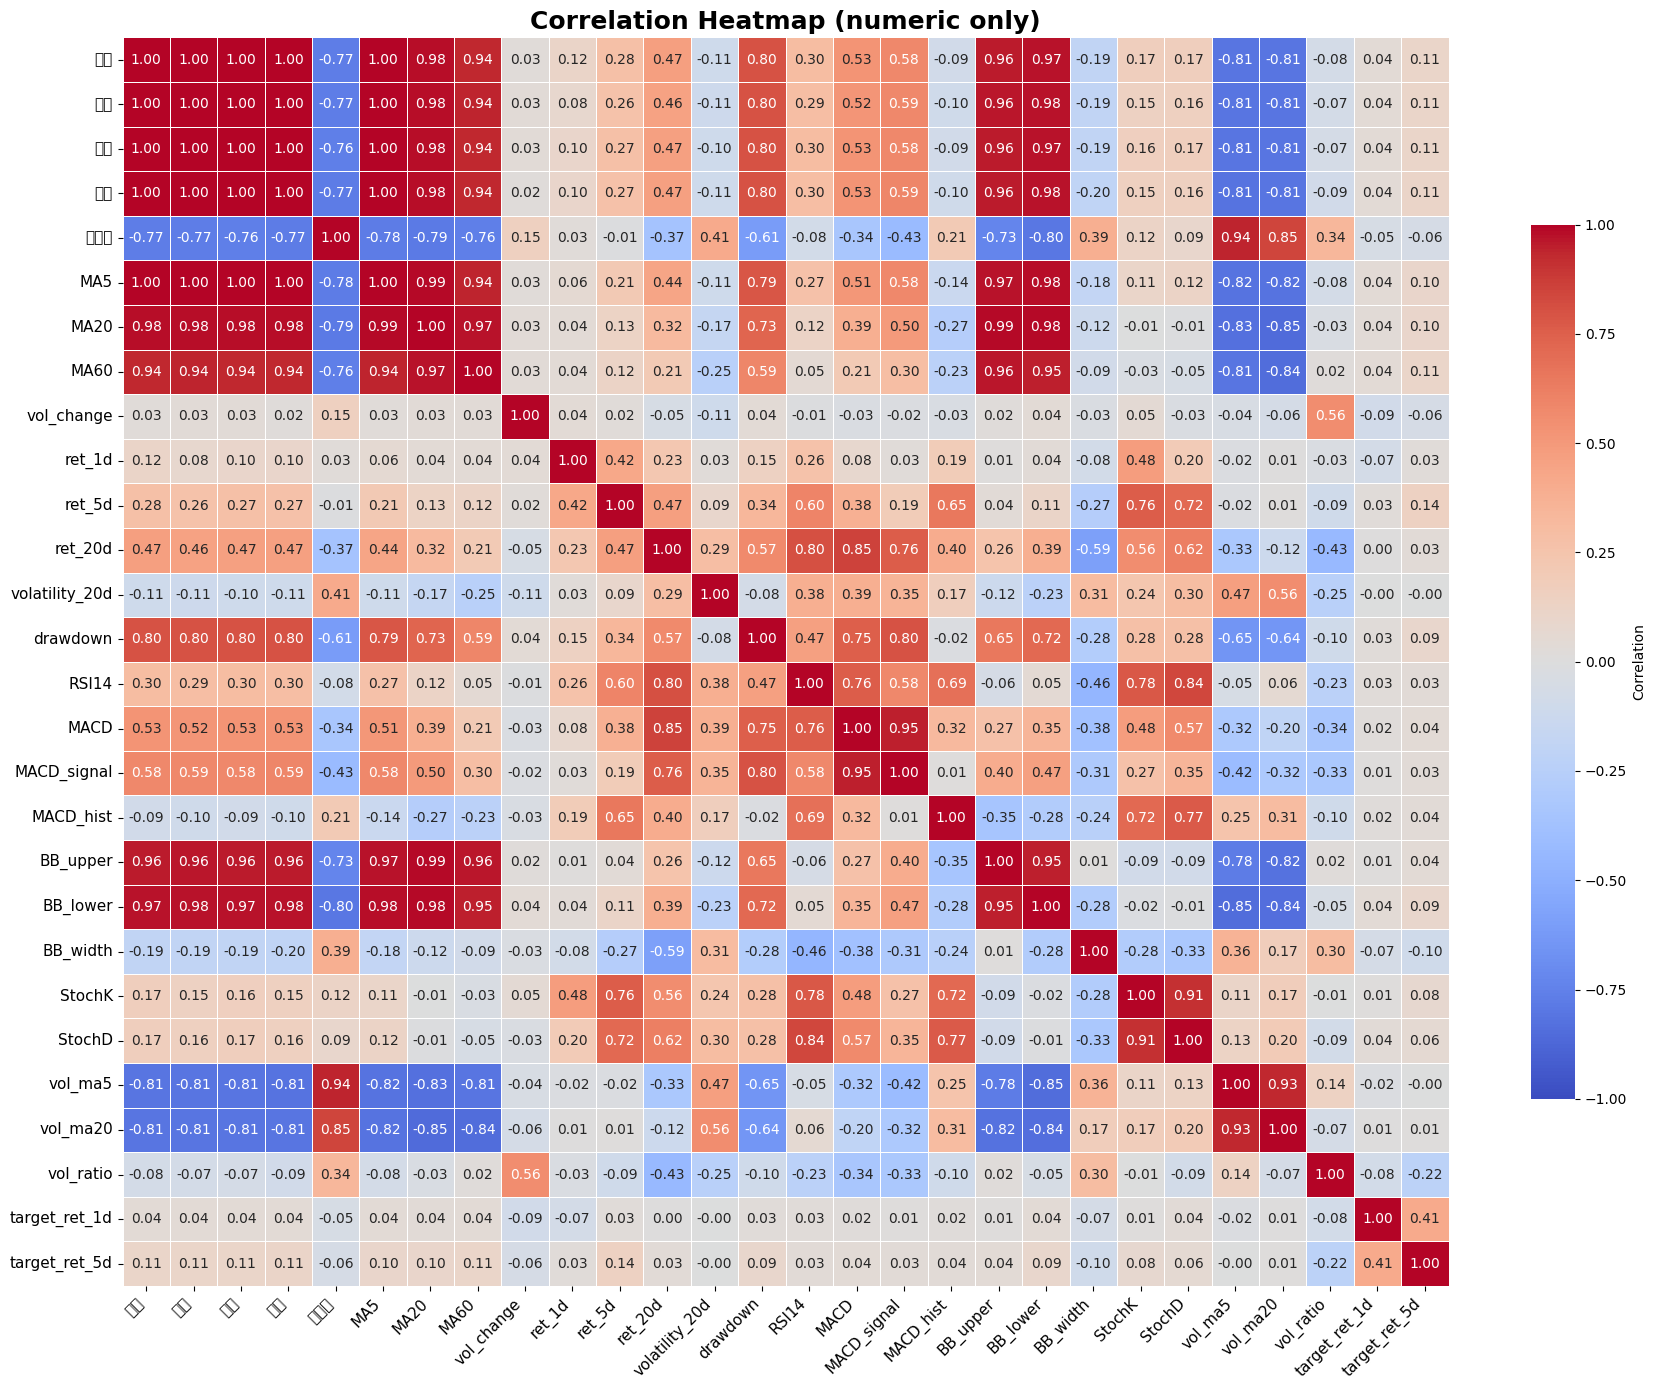


[7] 모델링 및 백테스트 실행
[RF] 자동 threshold 선택: 0.400 (train F1=1.000)

=== Feature Importance (Top 3) ===
   feature  importance
    StochK    0.136239
    StochD    0.060549
vol_change    0.059036

=== 모델 성능 ===
Logistic: acc=0.4750, f1=0.5532, auc=0.8177
RandomForest: acc=0.6750, f1=0.5806, auc=0.7749
XGBoost: acc=0.6500, f1=0.5882, auc=0.8405

=== 전략 성과 ===
Rule   : total_return=-0.1030, CAGR=-0.4959, MDD=-0.1088
Model  : total_return=-0.1002, CAGR=-0.4858, MDD=-0.1404
BuyHold: total_return=-0.2697, CAGR=-0.8619, MDD=-0.2817

모델링/백테스트 완료.

프로세스 완료.


In [1]:
"""
Update Summary – Improved Visualization & Modeling Integration

This version includes several enhancements aimed at producing more meaningful visual outputs
and improving the interpretability of the model results for reporting and presentation:

1. Added technical indicators (RSI, MACD, Bollinger Bands, Stochastic, Volume Ratio)
   → Provides richer feature context and more realistic trading signals.

2. Improved handling of imbalanced classes using class_weight='balanced'
   → Prevents the model from predicting only one class (e.g., constant "0" in down-trending markets).

3. Implemented automatic threshold optimization for RandomForest
   → Instead of using a fixed threshold (e.g., 0.55), the model now selects the best threshold
     based on training performance (F1-score), resulting in more reasonable buy/sell signals.

4. Enhanced visualization layer for dashboard/report
   → Clearer price charts, buy/sell markers, NAV comparison, and model metric summaries.

5. Code structure remains compatible with the original pipeline
   → All improvements integrate smoothly without changing team responsibilities or workflow.

These updates make the analysis output more insightful and the final dashboard suitable for
presentation and evaluation.
"""

# ==========================================
# Stock Project Unified Pipeline (Improved)
# ==========================================

import os
import time
import json
import re
import glob
import datetime
import warnings

import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# optional XGBoost
try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

warnings.filterwarnings("ignore")

# ==========================================
# 1. 공통 상수 / 유틸 함수
# ==========================================

def parse_krw_hangeul(value):
    """
    거래대금(억) 단위의 한글 표현을 정수(원 단위)로 변환.
    예: "1,234억원" -> 123400000000
    """
    if value is None:
        return 0
    value = str(value).replace(',', '').replace(' ', '')
    if value.endswith('억원'):
        try:
            num = float(value.replace('억원', ''))
            return int(num * 100000000)
        except ValueError:
            return 0
    try:
        return int(value)
    except ValueError:
        return 0

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    ),
    "Accept": "application/json, text/plain, */*",
    "Referer": "https://m.stock.naver.com/",
    "Origin": "https://m.stock.naver.com",
}

def clean_value(value):
    """
    API 값에서 '배', '원', '억원', ',' 등을 제거해
    숫자만 남기거나 깔끔한 문자열로 정리.
    """
    if value is None or value == "":
        return "N/A"
    return (
        str(value)
        .replace('배', '')
        .replace('원', '')
        .replace('억원', '')
        .replace(',', '')
        .strip()
    )

# ==========================================
# 2. 거래량 상위 종목 / KOSPI 지수
# ==========================================

def get_top_stocks_data(pages=2, page_size=20):
    """
    네이버 금융 API에서 거래량 상위 주식 데이터를 가져와 DataFrame으로 반환.
    """
    base_api_url = "https://m.stock.naver.com/api/stocks/quantTop/all"
    fetched_data = []

    print(f"=== 상위 주식 데이터 크롤링 시작 (총 {pages * page_size}개 목표) ===")

    for i in range(1, pages + 1):
        full_url = f"{base_api_url}?page={i}&pageSize={page_size}"
        print(f" -> 페이지 {i} 요청 중...")

        try:
            response = requests.get(full_url, headers=HEADERS, timeout=5)
            response.raise_for_status()
            data = response.json()

            if isinstance(data, dict) and 'stocks' in data and isinstance(data['stocks'], list):
                fetched_data.extend(data['stocks'])
            else:
                print(f" -> 페이지 {i} 데이터 없음 혹은 형식 오류.")
                break
        except Exception as e:
            print(f" -> 페이지 {i} 오류 발생: {e}")
            break

        time.sleep(0.1)  # 서버 부하 방지용 딜레이

    if not fetched_data:
        print("거래량 상위 데이터를 가져오지 못했습니다.")
        return pd.DataFrame()

    df = pd.DataFrame(fetched_data)
    cols = {
        'itemCode': '종목코드',
        'stockName': '종목명',
        'closePrice': '현재가',
        'fluctuationsRatio': '등락률',
        'accumulatedTradingVolume': '거래량',
        'accumulatedTradingValueKrwHangeul': '거래대금',
    }
    available_cols = [c for c in cols.keys() if c in df.columns]
    df = df[available_cols].rename(columns=cols)

    if '거래대금' in df.columns:
        df['거래대금'] = df['거래대금'].apply(parse_krw_hangeul)

    return df

def get_kospi_info():
    """
    네이버에서 KOSPI 기본 정보 및 실시간 정보를 가져온다.
    반환값: {'basic': ..., 'realtime': ...}
    """
    basic_url = "https://m.stock.naver.com/api/index/KOSPI/basic"
    realtime_url = "https://polling.finance.naver.com/api/realtime/domestic/index/KOSPI"

    result = {}

    try:
        res = requests.get(basic_url, headers=HEADERS, timeout=5)
        res.raise_for_status()
        result['basic'] = res.json()
    except Exception as e:
        print(f"KOSPI 기본 정보 오류: {e}")
        result['basic'] = None

    try:
        res = requests.get(realtime_url, headers=HEADERS, timeout=5)
        res.raise_for_status()
        data = res.json()
        result['realtime'] = data.get('result', data)
    except Exception as e:
        print(f"KOSPI 실시간 정보 오류: {e}")
        result['realtime'] = None

    return result

def print_kospi_formatted(kospi_data):
    basic = kospi_data.get('basic')
    if not basic:
        print("KOSPI 정보를 불러오지 못했습니다.")
        return

    name = basic.get('stockName', 'KOSPI')
    price = basic.get('closePrice', 'N/A')
    change = basic.get('compareToPreviousClosePrice', '0')
    ratio = basic.get('fluctuationsRatio', '0')

    direction_info = basic.get('compareToPreviousPrice', {})
    direction_text = direction_info.get('text', '')
    symbol = " "
    if direction_text == '상승':
        symbol = "▲"
    elif direction_text == '하락':
        symbol = "▼"

    exchange_info = basic.get('stockExchangeType', {})
    nation = exchange_info.get('nationName', 'KR')
    ex_name = exchange_info.get('nameKor', '코스피')

    time_str = basic.get('localTradedAt', '')
    if 'T' in time_str:
        time_str = time_str.split('+')[0].replace('T', ' ')

    charts = basic.get('imageCharts', {})
    day_chart = charts.get('day', '정보 없음')

    print("┌──────────────────────────────────────────────────┐")
    print(f"│  🇰🇷  [{nation}] {ex_name} ({name}) 상세 현황      │")
    print("├──────────────────────────────────────────────────┤")
    print(f"│  현재지수  : {price:<33} │")
    print(f"│  등락률    : {symbol} {change} ({ratio}%) {direction_text:<15} │")
    print("├──────────────────────────────────────────────────┤")
    print(f"│  장 상태   : {basic.get('marketStatus')}                          │")
    print(f"│  기준시간  : {time_str:<26}  │")
    print(f"│  거래소    : {exchange_info.get('nameEng')} ({exchange_info.get('code')})              │")
    print("├──────────────────────────────────────────────────┤")
    print("│  📊 일봉 차트 (클릭하여 보기):                   │")
    print(f"│  {day_chart:<46}  │")
    print("└──────────────────────────────────────────────────┘")

# ==========================================
# 3. 종목코드 / 일별 시세
# ==========================================

def get_code_from_excel(stock_name, file_name='stockCodeInfo.xlsx'):
    """
    로컬 엑셀 파일에서 '회사명'으로 종목코드를 찾는다.
    - 종목코드는 0으로 시작하므로 문자열(str)로 읽어야 한다.
    """
    if not os.path.exists(file_name):
        print(f"오류: '{file_name}' 파일이 현재 폴더에 없습니다.")
        return None

    try:
        df = pd.read_excel(file_name, dtype={'종목코드': str})
        found_row = df[df['회사명'] == stock_name]
        if not found_row.empty:
            return str(found_row.iloc[0]['종목코드'])
        print(f"'{stock_name}'을(를) 엑셀 파일에서 찾을 수 없습니다.")
        return None
    except Exception as e:
        print(f"엑셀 파일 읽기 오류: {e}")
        return None

def get_daily_stock_prices(code, pages=10):
    """
    종목코드(code)를 받아 일별 시세를 가져와 DataFrame으로 반환.
    호출 URL: https://m.stock.naver.com/api/stock/{code}/price
    """
    url = f"https://m.stock.naver.com/api/stock/{code}/price"
    all_prices = []

    print(f"=== [{code}] 시세 데이터 요청 중... ===")

    for page in range(1, pages + 1):
        params = {"pageSize": 20, "page": page}
        try:
            response = requests.get(url, params=params, headers=HEADERS, timeout=5)
            response.raise_for_status()
            data = response.json()
            if data:
                all_prices.extend(data)
                print(f" -> {page}페이지 수집 성공 ({len(data)}건)")
            else:
                break
        except Exception as e:
            print(f"API 요청 오류: {e}")
            break
        time.sleep(0.1)

    if not all_prices:
        return pd.DataFrame()

    df = pd.DataFrame(all_prices)
    rename_map = {
        'localTradedAt': '날짜',
        'closePrice': '종가',
        'compareToPreviousClosePrice': '전일비',
        'openPrice': '시가',
        'highPrice': '고가',
        'lowPrice': '저가',
        'accumulatedTradingVolume': '거래량',
        'fluctuationsRatio': '등락률',
    }
    available = [c for c in rename_map.keys() if c in df.columns]
    return df[available].rename(columns=rename_map)

# ==========================================
# 4. 전처리 / 피처 엔지니어링 / EDA
# ==========================================

def process_time_series(df_ts, date_col='날짜', price_col='종가', volume_col='거래량', ticker=None):
    """
    단일 종목의 일별 시계열 DataFrame을 받아서:
    - 날짜 정리, 결측 처리, 이상치 처리
    - 이동평균(MA5, MA20, MA60), 거래량 변화율, 수익률(1/5/20), 변동성(20일), Drawdown
    - 추가 테크니컬 지표: RSI, MACD, Bollinger Band, Stochastic, volume ratio
    - 타깃(다음날 수익률, 5일 수익률) 생성
    반환: 처리된 DataFrame
    """
    df = df_ts.copy()

    # 날짜 정리
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values(by=date_col).reset_index(drop=True)

    # 숫자형 변환
    for c in [price_col, volume_col, '시가', '고가', '저가']:
        if c in df.columns:
            df[c] = df[c].astype(str).str.replace(',', '').replace('nan', np.nan)
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # 결측치 처리
    if price_col in df.columns:
        df[price_col] = df[price_col].interpolate(method='linear')
        df[price_col] = df[price_col].fillna(method='ffill').fillna(method='bfill')

    if volume_col in df.columns:
        df[volume_col] = df[volume_col].fillna(0)

    if price_col in df.columns:
        df = df[df[price_col] > 0].copy()

    # 이동평균
    for w in [5, 20, 60]:
        if price_col in df.columns:
            df[f"MA{w}"] = df[price_col].rolling(window=w, min_periods=1).mean()

    # 거래량 변화율
    if volume_col in df.columns:
        df['vol_change'] = df[volume_col].pct_change().replace([np.inf, -np.inf], np.nan)

    # 수익률
    if price_col in df.columns:
        df['ret_1d'] = df[price_col].pct_change(1)
        df['ret_5d'] = df[price_col].pct_change(5)
        df['ret_20d'] = df[price_col].pct_change(20)

    # 변동성
    if 'ret_1d' in df.columns:
        df['volatility_20d'] = df['ret_1d'].rolling(20).std()

    # Drawdown
    if price_col in df.columns:
        roll_max = df[price_col].rolling(window=60, min_periods=1).max()
        df['drawdown'] = df[price_col] / roll_max - 1

    # ====== 추가 테크니컬 인디케이터 ======

    # RSI(14)
    if price_col in df.columns:
        delta = df[price_col].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        window = 14
        avg_gain = gain.rolling(window, min_periods=window).mean()
        avg_loss = loss.rolling(window, min_periods=window).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df['RSI14'] = 100 - (100 / (1 + rs))
        df['RSI14'] = df['RSI14'].fillna(method='bfill')

    # MACD (12-26, signal 9)
    if price_col in df.columns:
        ema12 = df[price_col].ewm(span=12, adjust=False).mean()
        ema26 = df[price_col].ewm(span=26, adjust=False).mean()
        df['MACD'] = ema12 - ema26
        df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_hist'] = df['MACD'] - df['MACD_signal']

    # Bollinger Band (20)
    if price_col in df.columns and 'MA20' in df.columns:
        std20 = df[price_col].rolling(window=20, min_periods=20).std()
        df['BB_upper'] = df['MA20'] + 2 * std20
        df['BB_lower'] = df['MA20'] - 2 * std20
        df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['MA20']

    # Stochastic Oscillator (%K, %D)
    if price_col in df.columns and '고가' in df.columns and '저가' in df.columns:
        low14 = df['저가'].rolling(window=14, min_periods=14).min()
        high14 = df['고가'].rolling(window=14, min_periods=14).max()
        stoch_k = (df[price_col] - low14) / (high14 - low14)
        df['StochK'] = stoch_k
        df['StochD'] = df['StochK'].rolling(window=3, min_periods=3).mean()

    # Volume MA / Ratio
    if volume_col in df.columns:
        df['vol_ma5'] = df[volume_col].rolling(window=5, min_periods=1).mean()
        df['vol_ma20'] = df[volume_col].rolling(window=20, min_periods=1).mean()
        df['vol_ratio'] = df[volume_col] / df['vol_ma20'].replace(0, np.nan)

    # 타깃 생성
    if 'ret_1d' in df.columns:
        df['target_ret_1d'] = df['ret_1d'].shift(-1)
    if 'ret_5d' in df.columns:
        df['target_ret_5d'] = df['ret_5d'].shift(-5)

    # ticker
    if ticker:
        df['ticker'] = ticker
    else:
        if 'ticker' not in df.columns:
            df['ticker'] = 'UNKNOWN'

    if date_col in df.columns:
        df = df.sort_values(by=date_col).reset_index(drop=True)

    return df

def eda_and_visualize(df, date_col='날짜', price_col='종가'):
    """
    간단한 EDA 시각화:
    - 가격 & 이동평균 (plotly)
    - 1일 수익률 분포/박스플롯
    - 숫자형 컬럼 상관관계 heatmap
    """
    numeric_df = df.select_dtypes(include=[np.number])

    # 가격 + 이동평균
    try:
        if price_col in df.columns:
            fig = go.Figure()
            x = df[date_col] if date_col in df.columns else df.index
            fig.add_trace(go.Scatter(x=x, y=df[price_col], mode='lines', name='Close'))
            for ma in ['MA5', 'MA20', 'MA60']:
                if ma in df.columns:
                    fig.add_trace(go.Scatter(x=x, y=df[ma], mode='lines', name=ma))
            fig.update_layout(title='Price & Moving Averages', xaxis_title='Date', yaxis_title='Price')
            fig.show()
    except Exception as e:
        print("Plotly 가격 그래프 생성 중 오류:", e)

    # 1일 수익률 분포
    try:
        if 'ret_1d' in df.columns:
            plt.figure(figsize=(10, 4))
            sns.histplot(df['ret_1d'].dropna(), bins=100, kde=False)
            plt.title('1-day Return Distribution')
            plt.xlabel('ret_1d')
            plt.show()

            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df['ret_1d'].dropna())
            plt.title('1-day Return Boxplot')
            plt.xlabel('ret_1d')
            plt.show()
    except Exception as e:
        print("수익률 분포/박스플롯 생성 중 오류:", e)

    # 상관관계 히트맵
    try:
        if numeric_df.shape[1] > 1:
            plt.figure(figsize=(18,14))
            corr = numeric_df.corr()

            sns.heatmap(
                corr,
                cmap='coolwarm',
                vmin=-1, vmax=1,
                annot=True,
                fmt=".2f",
                linewidths=0.5,
                cbar_kws={"shrink": 0.7, "label" : "Correlation"}
            )

            plt.xticks(rotation=45, ha="right", fontsize=11)
            plt.yticks(rotation=0, fontsize=11)
            plt.title('Correlation Heatmap (numeric only)', fontsize=18, fontweight='bold')
            plt.tight_layout()
            plt.show()
        else:
            print("Heatmap 생략 — 숫자형 컬럼이 부족합니다.")
    except Exception as e:
        print("히트맵 생성 중 오류:", e)

def safe_save_csv(df, path):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    df.to_csv(path, index=False)

def load_latest_processed(path="data/processed", pattern="merged_data_*.csv"):
    files = sorted(glob.glob(os.path.join(path, pattern)))
    if not files:
        raise FileNotFoundError("processed CSV가 없습니다. 먼저 전처리 파이프라인을 실행하세요.")
    latest = files[-1]
    print("Loaded:", latest)
    return pd.read_csv(latest), latest

# ==========================================
# 5. 기본 체크/백테스트 + 모델링
# ==========================================

def ensure_basic(df):
    rename_map = {
        '일간수익률': 'ret_1d',
        '주간수익률': 'ret_5d',
        '월간수익률': 'ret_20d',
        '변동성_20': 'volatility_20d',
        '고점대비하락률': 'drawdown',
        '거래량변화율': 'vol_change',
    }
    df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})
    if '종가' not in df.columns or 'ret_1d' not in df.columns:
        raise KeyError("필수 컬럼(종가, ret_1d)이 필요합니다.")
    return df

def backtest_series(df, signal_col='signal', price_col='종가',
                    initial_capital=1_000_000, fee=0.0005, slippage=0.0002):
    df = df.reset_index(drop=True).copy()
    cash = initial_capital
    shares = 0.0
    nav = []
    for i in range(len(df) - 1):
        nav.append(cash + shares * df.loc[i, price_col])
        sig = int(df.loc[i, signal_col])
        nxt = df.loc[i + 1, price_col]
        if sig == 1 and cash > 0:
            amt = cash
            shares += amt * (1 - fee - slippage) / nxt
            cash = 0
        elif sig == 0 and shares > 0:
            cash += shares * nxt * (1 - fee - slippage)
            shares = 0
    nav.append(cash + shares * df.loc[len(df) - 1, price_col])
    return pd.Series(nav)

def perf_from_nav(nav, initial_capital=1_000_000):
    total = float(nav.iloc[-1] / initial_capital - 1)
    days = len(nav)
    years = days / 252 if days > 0 else 0
    cagr = (nav.iloc[-1] / initial_capital) ** (1 / years) - 1 if years > 0 else float('nan')
    mdd = float(((nav - nav.cummax()) / nav.cummax()).min())
    return {'total_return': total, 'CAGR': cagr, 'MDD': mdd}

def run_c3_pipeline_allmodels(df=None, features=None,
                              model_threshold=None,  # None이면 자동 탐색
                              initial_capital=1_000_000, fast=False):
    if df is None:
        df, path = load_latest_processed()
    df = ensure_basic(df)

    # 기본 feature + 신규 인디케이터들
    base_features = [
        '종가', '시가', '고가', '저가', '거래량',
        'MA5', 'MA20', 'MA60',
        'volatility_20d', 'drawdown', 'vol_change',
        'RSI14', 'MACD', 'MACD_signal', 'MACD_hist',
        'BB_width', 'StochK', 'StochD',
        'vol_ma5', 'vol_ma20', 'vol_ratio',
    ]
    forbidden = {'ret_1d', 'ret_5d', 'ret_20d', 'target_ret_1d', 'target_ret_5d', 'target'}
    feat_list = [c for c in base_features if c in df.columns and c not in forbidden]
    if features:
        feat_list = [c for c in features if c in df.columns and c not in forbidden]
    if not feat_list:
        raise ValueError("사용 가능한 feature가 없습니다. 전처리 결과를 확인하세요.")

    # 숫자형/결측 처리
    df[feat_list] = df[feat_list].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=['종가', 'ret_1d']).copy()
    df[feat_list] = df[feat_list].fillna(method='ffill').fillna(method='bfill').fillna(0)
    df['target'] = (df['ret_1d'] > 0).astype(int)

    # Train / Test 분할
    split_idx = int(len(df) * 0.8)
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:].reset_index(drop=True)

    X_train, y_train = train[feat_list], train['target']
    X_test, y_test = test[feat_list], test['target']

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # class imbalance 보정
    pos_count = y_train.sum()
    neg_count = len(y_train) - pos_count
    if pos_count == 0:
        pos_weight = 1.0
    else:
        pos_weight = neg_count / pos_count

    rf_n = 50 if fast else 200
    xgb_n = 50 if fast else 200

    models = {
        'Logistic': LogisticRegression(max_iter=400, class_weight='balanced'),
        'RandomForest': RandomForestClassifier(
            n_estimators=rf_n,
            random_state=42,
            class_weight='balanced'
        ),
    }
    if _HAS_XGB:
        models['XGBoost'] = XGBClassifier(
            n_estimators=xgb_n,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=pos_weight
        )

    perf = {}
    trained = {}

    # ====== 모델 학습 & 평가 ======
    for name, m in models.items():
        m.fit(X_train_s, y_train)
        pred = m.predict(X_test_s)
        try:
            proba = m.predict_proba(X_test_s)[:, 1]
        except Exception:
            proba = np.zeros(len(pred))
        try:
            auc_v = float(roc_auc_score(y_test, proba))
        except Exception:
            auc_v = float('nan')
        perf[name] = {
            'accuracy': float(accuracy_score(y_test, pred)),
            'f1': float(f1_score(y_test, pred)),
            'auc': auc_v,
        }
        trained[name] = m

    # ====== RandomForest 기준 시그널 생성 ======
    rf = trained.get('RandomForest', None)
    if rf is not None:
        proba_test = rf.predict_proba(X_test_s)[:, 1]

        # threshold 자동 탐색 (train 데이터 기준)
        if model_threshold is None:
            proba_tr = rf.predict_proba(X_train_s)[:, 1]
            best_thr = 0.5
            best_f1 = -1.0
            for thr in np.linspace(0.4, 0.6, 21):
                pred_thr = (proba_tr > thr).astype(int)
                f1_thr = f1_score(y_train, pred_thr)
                if f1_thr > best_f1:
                    best_f1 = f1_thr
                    best_thr = thr
            model_threshold = best_thr
            print(f"[RF] 자동 threshold 선택: {model_threshold:.3f} (train F1={best_f1:.3f})")
        else:
            print(f"[RF] 사용자 지정 threshold 사용: {model_threshold:.3f}")

        test['proba'] = proba_test
        test['model_signal'] = (test['proba'] > model_threshold).astype(int)
    else:
        test['proba'] = 0.0
        test['model_signal'] = 0

    # ====== 단순 룰 시그널 (MA 크로스) ======
    if 'MA5' in test.columns and 'MA20' in test.columns:
        test['rule_signal'] = (test['MA5'] > test['MA20']).astype(int)
    else:
        test['rule_signal'] = 0

    # ====== 백테스트 ======
    nav_rule = backtest_series(test, signal_col='rule_signal',
                               price_col='종가', initial_capital=initial_capital)
    nav_model = backtest_series(test, signal_col='model_signal',
                                price_col='종가', initial_capital=initial_capital)
    nav_bh = (test['종가'] / test['종가'].iloc[0]) * initial_capital

    perf_rule = perf_from_nav(nav_rule, initial_capital)
    perf_model = perf_from_nav(nav_model, initial_capital)
    perf_bh = perf_from_nav(nav_bh.reset_index(drop=True), initial_capital)

    # ====== Feature Importance ======
    feat_imp = None
    if 'RandomForest' in trained:
        try:
            rf_imp = trained['RandomForest'].feature_importances_
            feat_imp = pd.DataFrame({'feature': feat_list, 'importance': rf_imp}) \
                         .sort_values('importance', ascending=False) \
                         .reset_index(drop=True)
        except Exception:
            feat_imp = None
    elif 'XGBoost' in trained:
        try:
            x_imp = trained['XGBoost'].feature_importances_
            feat_imp = pd.DataFrame({'feature': feat_list, 'importance': x_imp}) \
                         .sort_values('importance', ascending=False) \
                         .reset_index(drop=True)
        except Exception:
            feat_imp = None

    if feat_imp is not None and not feat_imp.empty:
        top3 = feat_imp.head(3).copy().reset_index(drop=True)
        print("\n=== Feature Importance (Top 3) ===")
        print(top3.to_string(index=False))
        os.makedirs('output', exist_ok=True)
        top3.to_csv('output/feature_importance_top3.csv', index=False)
    else:
        print("\n(Feature importance not available)")

    # ====== 결과 저장 ======
    os.makedirs('output', exist_ok=True)
    safe_save_csv(test, 'output/strategy_signals.csv')
    summary = {
        'models': perf,
        'rule_perf': perf_rule,
        'model_perf': perf_model,
        'bh_perf': perf_bh,
        'model_threshold': model_threshold,
    }
    with open('output/c3_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, ensure_ascii=False, indent=2)

    print("\n=== 모델 성능 ===")
    for k, v in perf.items():
        print(f"{k}: acc={v['accuracy']:.4f}, f1={v['f1']:.4f}, auc={v['auc']:.4f}")
    print("\n=== 전략 성과 ===")
    print(f"Rule   : total_return={perf_rule['total_return']:.4f}, CAGR={perf_rule['CAGR']:.4f}, MDD={perf_rule['MDD']:.4f}")
    print(f"Model  : total_return={perf_model['total_return']:.4f}, CAGR={perf_model['CAGR']:.4f}, MDD={perf_model['MDD']:.4f}")
    print(f"BuyHold: total_return={perf_bh['total_return']:.4f}, CAGR={perf_bh['CAGR']:.4f}, MDD={perf_bh['MDD']:.4f}")

    return {
        'trained': trained,
        'perf': perf,
        'summary': summary,
        'signals': test,
        'nav_rule': nav_rule,
        'nav_model': nav_model,
        'nav_bh': nav_bh,
        'feat_imp': feat_imp,
    }

def run_c3_pipeline(df=None, features=None,
                    model_threshold=None,  # None이면 자동으로 최적 threshold 탐색
                    initial_capital=1_000_000, fast=False):
    """
    기존 코드와 호환을 위해 남긴 래퍼 함수입니다.
    내부적으로 run_c3_pipeline_allmodels 를 호출합니다.
    """
    return run_c3_pipeline_allmodels(
        df=df,
        features=features,
        model_threshold=model_threshold,
        initial_capital=initial_capital,
        fast=fast,
    )

# ==========================================
# 6. 통합 실행 main()
# ==========================================

def main():
    print("\n[1] 거래량 상위 주식 목록 (상위 5개)")
    try:
        df_top = get_top_stocks_data()
        if not df_top.empty:
            print(df_top[['종목명', '종목코드', '현재가', '등락률', '거래량']].head(5))
        else:
            print("  거래량 상위 데이터를 가져오지 못했습니다.")
    except Exception as e:
        print("  거래량 상위 조회 오류:", e)

    print("\n[2] KOSPI 정보")
    try:
        kospi_data = get_kospi_info()
        print_kospi_formatted(kospi_data)
    except Exception as e:
        print("  KOSPI 조회 오류:", e)

    print("\n[3] 분석할 종목 선택")
    user_in = input("분석할 종목명(예: 삼성전자) 또는 6자리 종목코드, 또는 AUTO를 입력하세요: ").strip()

    if user_in.upper() == "AUTO":
        df_top = get_top_stocks_data()
        if df_top.empty:
            print("AUTO 실패: 거래량 상위 목록을 불러오지 못했습니다.")
            return
        target_name = df_top.iloc[0]['종목명']
        code_for_fetch = df_top.iloc[0]['종목코드']
        print(f"AUTO 선택: 거래량 1위 종목 -> {target_name} ({code_for_fetch})")
    else:
        if re.match(r'^\d{6}$', user_in):
            code_for_fetch = user_in
            target_name = user_in
        else:
            target_name = user_in
            code_for_fetch = get_code_from_excel(target_name)
            if not code_for_fetch:
                print("종목코드를 찾을 수 없습니다.")
                return

    print(f"\n[4] 시세 데이터 수집: {target_name} ({code_for_fetch})")
    df_price = get_daily_stock_prices(code_for_fetch, pages=10)
    if df_price.empty:
        print("시세 데이터를 가져오지 못했습니다.")
        return

    print("\n[5] 전처리 및 피처 엔지니어링")
    processed = process_time_series(
        df_price,
        date_col='날짜',
        price_col='종가',
        volume_col='거래량',
        ticker=target_name
    )
    processed = processed.sort_values('날짜').reset_index(drop=True)
    if '종가' in processed.columns:
        processed['종가'] = processed['종가'].interpolate().ffill().bfill()
    if '거래량' in processed.columns:
        processed['거래량'] = processed['거래량'].fillna(0)

    os.makedirs("data/processed", exist_ok=True)
    out_path = os.path.join("data/processed", f"merged_data_{code_for_fetch}.csv")
    processed.to_csv(out_path, index=False)
    print(f"전처리 데이터 저장: {out_path}")

    print("\n[6] EDA 시각화 (선택적)")
    try:
        eda_and_visualize(processed, date_col='날짜', price_col='종가')
    except Exception as e:
        print("EDA 실행 중 오류:", e)

    print("\n[7] 모델링 및 백테스트 실행")
    try:
        _ = run_c3_pipeline(
            df=processed,
            features=None,
            model_threshold=None,   # 자동으로 최적 threshold 탐색
            initial_capital=1_000_000,
            fast=False
        )
        print("\n모델링/백테스트 완료.")
    except Exception as e:
        print("모델/백테스트 실행 중 오류:", e)

    print("\n프로세스 완료.")

if __name__ == "__main__":
    main()